# EDA v06

Montar dataset de cliente
Cada linha será um cliente e deve contar as informações:

dados descritivos:
- nome
- idade
- sexo
- cidade

dados da divida:
- ✔️ tem divida
- ✔️ valor total da divida
- ✔️ dias vencido (aging)
- ➖ quantidade de faturas devendo
- ✔️ é FPD (First Payment Defaul) -> devem a primeira fatura
- ✔️ é PDD (Provisão para Devedores Duvidosos) -> devem mais de 90 dias

dados demográficos
- Nível de instrução
- Domicílios por número de moradores
- Domicílios por condição de ocupação
- Domicílios por tipo
- Domicílios por faixa de rendimento domiciliar mensal
- PIB
- PIB per cap


# ML
---

Base line (**47.49%** dos cliente da base são inadimplentes - _com 95% de confiança que entre 27.49% e 67.49%_ se tornarão inadimplentes)

Aplicar moodelos de previsão de inadimplencia (encontrar váriaveis preditoras)

### Aplicar _K-means_

- _**O Algoritimo irá indicar grupos pelas similaridade das features**_
- encontrar PCA 
- encontar numeros de k
- aplicar agrupamento no df
- analisar grupos do K-means

### Modelo de classificação
 
- _**O contratante irá se tornar um inadimplente? (S/N)**_
- classificar por faixa de aging da divida (grupo)
    
### Modelo de regressão 

- _**Quanto o contratate irá dever? (valr R$)**_


### Econometria

## Importanto libs

In [2]:
from datetime import datetime
import re
import unicodedata
import numpy as np
import pandas as pd
import pandas_profiling

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler #normalização

from IPython.display import Markdown as md

In [3]:
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 100)

In [4]:
sns.set_color_codes
sns.set(rc={'figure.figsize':(15,10)})

## Carregando os dados

Criando drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/drive/MyDrive/Ligue/inadimplencia/dados/tratados/df_faturas_em_aberto_raw.csv', infer_datetime_format=True)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (37,38,39) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75596 entries, 0 to 75595
Data columns (total 88 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Unnamed: 0                              75596 non-null  int64  
 1   codigo_contrato                         75032 non-null  float64
 2   codigo_conta                            75596 non-null  object 
 3   valor_lancamento                        75596 non-null  float64
 4   valor_acrescimo                         75596 non-null  float64
 5   valor_desconto                          75596 non-null  float64
 6   situacao                                75596 non-null  object 
 7   tipo_lancamento                         75596 non-null  object 
 8   data_lancamento                         75596 non-null  object 
 9   data_vencimento_original                75596 non-null  object 
 10  data_vencimento                         75596 non-null  ob

#### Gera grupos de vencimentos

- <0
- 0-45
- 45-60
- 60-90
- \>90

In [7]:
def grupo_vencimento(x):
    if x['dias_vencido'] >= 0 and x['dias_vencido'] < 45:
        return '0-45'
    elif x['dias_vencido'] >= 45 and x['dias_vencido'] < 60:
        return '45-60'
    elif x['dias_vencido'] >= 60 and x['dias_vencido'] < 90:
        return '60-90'
    elif x['dias_vencido'] > 90:
        return '>90'
    else: 
        return '<0'

df['grupo_vencimento'] = df.apply(lambda x: grupo_vencimento(x), axis=1 )

#### Gera grupos de idade

- 0-18
- 18-25
- 25-35
- 35-45
- 45-55
- \>55

In [8]:
df['grupo_idade'] = np.nan

lst = [df]

for col in lst:
    col.loc[(col['idade'] > 0) & (col['idade'] <= 18), 'grupo_idade'] = 'Crianca'
    col.loc[(col['idade'] > 18) & (col['idade'] <= 25), 'grupo_idade'] = 'Jovem'
    col.loc[(col['idade'] > 25) & (col['idade'] <= 35), 'grupo_idade'] = 'Joven Adulto'
    col.loc[(col['idade'] > 35) & (col['idade'] <= 45), 'grupo_idade'] = 'Adulto'
    col.loc[(col['idade'] > 45) & (col['idade'] <= 55), 'grupo_idade'] = 'Adulto Velho'
    col.loc[ col['idade'] > 55, 'grupo_idade'] = 'Idoso' 

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75596 entries, 0 to 75595
Data columns (total 90 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Unnamed: 0                              75596 non-null  int64  
 1   codigo_contrato                         75032 non-null  float64
 2   codigo_conta                            75596 non-null  object 
 3   valor_lancamento                        75596 non-null  float64
 4   valor_acrescimo                         75596 non-null  float64
 5   valor_desconto                          75596 non-null  float64
 6   situacao                                75596 non-null  object 
 7   tipo_lancamento                         75596 non-null  object 
 8   data_lancamento                         75596 non-null  object 
 9   data_vencimento_original                75596 non-null  object 
 10  data_vencimento                         75596 non-null  ob

In [ ]:
df.head()

,Unnamed: 0,codigo_contrato,codigo_conta,valor_lancamento,valor_acrescimo,valor_desconto,situacao,tipo_lancamento,data_lancamento,data_vencimento_original,data_vencimento,data_liquidacao,fatura,observacao,descricao,descricao_fatura,status_x,movimento,valor_saldo,registrado_spc,registrado_spc_serasa,data_vencimento_dia_util,chave,codigo_cliente,situacao_cliente,nome_razao_social,fantasia,tipo_cliente,cpf_cnpj,rg_inscricao_estadual,inscricao_municipal,endereco,numero,complemento,bairro,cep,email_x,telefone1,telefone2,data_cadastro,data_bloq_conexao,natureza,chave_regiao,codigo_ibge,estado_sigla,codigo_ibge_estado,codigo_pais,cidade,pais,estado,latitude,longitude,codigo_municipio,populacao_referencia,populacao,codigo_regiao_geografica_imediata,nome_regiao_geografica_imediata,codigo_regiao_geografica_intermediaria,nome_regiao_geografica_intermediaria,codigo_microregiao,codigo_messoregiao,sigla_macroregiao,macroregiao,microregiao,mesorregiao,dias_vencido,cache_hit,cd_cache_serasa,data_busca_cache,data_busca_serasa,email_y,hora,processo,situacao_documento,status_y,total_cheques,total_divida,total_ocorrencias,total_origens,total_protestos,variaveis_reprovacao,sexo,data_nascimento,idade,primeiro_nome,contratos,valor_divida,inicio_divida,grupo_vencimento,grupo_idade
0,0,168389.0,CTR|168389|002,137.83,0.0,0.0,TITULO EM ABERTO,CTR,2022-04-21,2022-05-15,2022-05-15,NaN,2,N/I,FATURAMENTO,BOL,TITULO EM ABERTO,RECEBER,137.83,NaN,N/I,2022-05-16,1000000058770431,58770431,ATIVO,RAQUEL SOARES FRANCA,RAQUEL SOARES FRANCA,PESSOA FISICA,5877043145,1631616,N/I,"RUA ROSA ABUSSAFI DOS SANTOS,70",N/I,CASA,PORTAL CAIOBA II,79096719,RAQUELSOARES15@GMAIL.COM,991476361,992938712,NaN,NaN,103001,MS02704,5002704.0,MS,50.0,1058.0,CAMPO GRANDE,BRASIL,MATO GROSSO DO SUL,-20.447497,-54.619369,2704.0,N/I,0.0,500001.0,CAMPO GRANDE,5001.0,CAMPO GRANDE,4.0,2.0,CO,CENTRO OESTE,CAMPO GRANDE,CENTRO NORTE DE MATO GROSSO DO SUL,-5,N,134176,2022-02-19,2022-02-19,RAQUELSOARES15@GMAIL.COM,12:37:39,Televendas_-_Venda_Nova,REGULAR,VIABILIDADE,0,0.00,0.0,0,0,APROVADO;,F,1900-01-01,122,RAQUEL,1.0,0.00,2022-03-10,<0,Idoso
1,1,168389.0,CTR|168389|001,105.97,0.0,0.0,TITULO EM BORDERO,CTR,2022-03-21,2022-04-15,2022-04-15,NaN,1,N/I,FATURAMENTO,BOL,TITULO EM BORDERO,RECEBER,105.97,NaN,N/I,2022-04-15,1000000058770431,58770431,ATIVO,RAQUEL SOARES FRANCA,RAQUEL SOARES FRANCA,PESSOA FISICA,5877043145,1631616,N/I,"RUA ROSA ABUSSAFI DOS SANTOS,70",N/I,CASA,PORTAL CAIOBA II,79096719,RAQUELSOARES15@GMAIL.COM,991476361,992938712,NaN,NaN,103001,MS02704,5002704.0,MS,50.0,1058.0,CAMPO GRANDE,BRASIL,MATO GROSSO DO SUL,-20.447497,-54.619369,2704.0,N/I,0.0,500001.0,CAMPO GRANDE,5001.0,CAMPO GRANDE,4.0,2.0,CO,CENTRO OESTE,CAMPO GRANDE,CENTRO NORTE DE MATO GROSSO DO SUL,25,N,134176,2022-02-19,2022-02-19,RAQUELSOARES15@GMAIL.COM,12:37:39,Televendas_-_Venda_Nova,REGULAR,VIABILIDADE,0,0.00,0.0,0,0,APROVADO;,F,1900-01-01,122,RAQUEL,1.0,0.00,2022-03-10,0-45,Idoso
2,2,166806.0,CTR|166806|003,153.20,0.0,0.0,TITULO EM ABERTO,CTR,2022-04-26,2022-05-15,2022-05-15,NaN,3,N/I,FATURAMENTO,BOL,TITULO EM ABERTO,RECEBER,153.20,NaN,N/I,2022-05-16,1000000125050669,125050669,ATIVO,YASMIN EDUARDA PIRES,YASMIN EDUARDA PIRES,PESSOA FISICA,12505066973,146778097,N/I,"RUA OURO BRANCO,730",N/I,CASA,CENTRO,86808160,DP5812265@GMAIL.COM,996370774,991637112,NaN,NaN,103001,PR01408,4101408.0,PR,41.0,1058.0,APUCARANA,BRASIL,PARANA,-23.611621,-51.404872,1408.0,N/I,0.0,410023.0,APUCARANA,4105.0,LONDRINA,10.0,3.0,S,SUL,APUCARANA,NORTE CENTRAL PARANAENSE,-5,N,130985,2022-02-14,2022-02-14,dp5812265@gmail.com,16:47:38,Televendas_-_Venda_Nova,REGULAR,VIABILIDADE,0,0.00,0.0,0,0,APROVADO;,F,1900-01-01,122,YASMIN,1.0,30.94,2022-03-15,<0,Idoso
3,3,166806.0,CTR|166806|002,119.90,0.0,0.0,TITULO EM BORDERO,CTR,2022-03-26,2022-04-15,2022-04-15,NaN,2,N/I,FATURAMENTO,BOL,TITULO EM BORDERO,RECEBER,119.90,NaN,N/I,2022-04-15,1000000125050669,125050669,ATIVO,YASMIN EDUARDA PIRES,YASMIN EDUARDA PIRES,PESSOA FISICA,12505066973,146778097,N/I,"RUA OURO BRANCO,

In [ ]:
features = [
    'cpf_cnpj',
    'nome_razao_social',
    'sexo',
    'idade',
    'grupo_idade',
    'cidade',
    'estado',
    'macroregiao',
    'codigo_contrato',
    'fatura',
    'situacao',
    'dias_vencido',
    'grupo_vencimento',
    'valor_lancamento',
    'valor_divida']

df[features]

,cpf_cnpj,nome_razao_social,sexo,idade,grupo_idade,cidade,estado,macroregiao,codigo_contrato,fatura,situacao,dias_vencido,grupo_vencimento,valor_lancamento,valor_divida
0,5877043145,RAQUEL SOARES FRANCA,F,122,Idoso,CAMPO GRANDE,MATO GROSSO DO SUL,CENTRO OESTE,168389.0,2,TITULO EM ABERTO,-5,<0,137.83,0.00
1,5877043145,RAQUEL SOARES FRANCA,F,122,Idoso,CAMPO GRANDE,MATO GROSSO DO SUL,CENTRO OESTE,168389.0,1,TITULO EM BORDERO,25,0-45,105.97,0.00
2,12505066973,YASMIN EDUARDA PIRES,F,122,Idoso,APUCARANA,PARANA,SUL,166806.0,3,TITULO EM ABERTO,-5,<0,153.20,30.94
3,12505066973,YASMIN EDUARDA PIRES,F,122,Idoso,APUCARANA,PARANA,SUL,166806.0,2,TITULO EM BORDERO,25,0-45,119.90,30.94
4,3745980964,CLEUZA APARECIDA DO NASCIMENTO,F,48,Adulto Velho,CIANORTE,PARANA,SUL,167794.0,2,TITULO EM ABERTO,-5,<0,109.90,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75591,8683720802,EVERALDO TENORIO DA SILVA,M,122,Idoso,PEABIRU,PARANA,SUL,167867.0,3,TITULO EM ABERTO,-5,<0,109.90,3.54
75592,4812278902,MARCOS PAULO CARDOSO,M,37,Adulto,MARINGA,PARANA,SUL,165566.0,3,TITULO EM ABERTO,-5,<0,119.90,0.00
75593,87224283134,LUIZ CARLOS BENITE RIBAS,M,122,Idoso,CAMPO GRANDE,MATO GROSSO DO SUL,CENTRO OESTE,164523.0,3,TITULO EM ABERTO,-5,<0,109.90,0.00
75594,94478767149,ADIR DOMINGUES EVANGELISTA,M,44,Adulto,CAMPO GRANDE,MATO GROSSO DO SUL,CENTRO OESTE,167388.0,3,TITULO EM ABERTO,-5,<0,109.90,0.00


In [ ]:
df.shape, df[df['dias_vencido'] > 0].shape

((75596, 90), (59373, 90))

In [ ]:
df[df['dias_vencido'] > 0][features]

,cpf_cnpj,nome_razao_social,sexo,idade,grupo_idade,cidade,estado,macroregiao,codigo_contrato,fatura,situacao,dias_vencido,grupo_vencimento,valor_lancamento,valor_divida
1,5877043145,RAQUEL SOARES FRANCA,F,122,Idoso,CAMPO GRANDE,MATO GROSSO DO SUL,CENTRO OESTE,168389.0,1,TITULO EM BORDERO,25,0-45,105.97,0.00
3,12505066973,YASMIN EDUARDA PIRES,F,122,Idoso,APUCARANA,PARANA,SUL,166806.0,2,TITULO EM BORDERO,25,0-45,119.90,30.94
5,3745980964,CLEUZA APARECIDA DO NASCIMENTO,F,48,Adulto Velho,CIANORTE,PARANA,SUL,167794.0,1,TITULO EM BORDERO,25,0-45,94.20,0.00
7,8986375117,EDUARDO OLIVEIRA CAMARGO,M,122,Idoso,CAMPO GRANDE,MATO GROSSO DO SUL,CENTRO OESTE,168013.0,1,TITULO EM BORDERO,25,0-45,119.90,0.00
11,2263029117,ANDRE LUIS GONCALVES DA SILVA,M,122,Idoso,CAMPO GRANDE,MATO GROSSO DO SUL,CENTRO OESTE,174352.0,1,TITULO EM BORDERO,25,0-45,18.56,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75524,41296400972,CICERO VICENTE DE MELLO,M,122,Idoso,CIANORTE,PARANA,SUL,172216.0,1,TITULO EM BORDERO,30,0-45,77.08,0.00
75578,21049130987,ANA MARIA DOS SANTOS,F,122,Idoso,MARINGA,PARANA,SUL,158548.0,4,TITULO EM ABERTO,5,0-45,109.90,0.00
75579,12325100928,STHEFANY CRISTINA DA COSTA,F,122,Idoso,MARIALVA,PARANA,SUL,160825.0,3,TITULO EM ABERTO,5,0-45,109.90,109.90
75580,15089202494,SAMUEL VIANA BRANDAO,M,122,Idoso,ROLANDIA,PARANA,SUL,158850.0,4,TITULO EM ABERTO,5,0-45,109.90,0.00


In [ ]:
df['cpf_cnpj'].value_counts()

41140626000180    13
66225612904       12
80067374956       12
7673313979        11
4921354952        11
                  ..
4515891146         1
6093419959         1
10152469907        1
8979023944         1
45003059000171     1
Name: cpf_cnpj, Length: 36400, dtype: int64

In [ ]:
cpf_cnpj_qnt_faturas_vencidas = df[df['dias_vencido'] > 0]['cpf_cnpj'].value_counts()

In [ ]:
type(cpf_cnpj_qnt_faturas_vencidas)

pandas.core.series.Series

In [ ]:
df[df['cpf_cnpj'] == 12505066973][features].sort_values('fatura')

,cpf_cnpj,nome_razao_social,sexo,idade,grupo_idade,cidade,estado,macroregiao,codigo_contrato,fatura,situacao,dias_vencido,grupo_vencimento,valor_lancamento,valor_divida
3,12505066973,YASMIN EDUARDA PIRES,F,122,Idoso,APUCARANA,PARANA,SUL,166806.0,2,TITULO EM BORDERO,25,0-45,119.9,30.94
2,12505066973,YASMIN EDUARDA PIRES,F,122,Idoso,APUCARANA,PARANA,SUL,166806.0,3,TITULO EM ABERTO,-5,<0,153.2,30.94


In [ ]:
devedores = df[df['dias_vencido'] > 0][features]

In [ ]:
devedores

,cpf_cnpj,nome_razao_social,sexo,idade,grupo_idade,cidade,estado,macroregiao,codigo_contrato,fatura,situacao,dias_vencido,grupo_vencimento,valor_lancamento,valor_divida
1,5877043145,RAQUEL SOARES FRANCA,F,122,Idoso,CAMPO GRANDE,MATO GROSSO DO SUL,CENTRO OESTE,168389.0,1,TITULO EM BORDERO,25,0-45,105.97,0.00
3,12505066973,YASMIN EDUARDA PIRES,F,122,Idoso,APUCARANA,PARANA,SUL,166806.0,2,TITULO EM BORDERO,25,0-45,119.90,30.94
5,3745980964,CLEUZA APARECIDA DO NASCIMENTO,F,48,Adulto Velho,CIANORTE,PARANA,SUL,167794.0,1,TITULO EM BORDERO,25,0-45,94.20,0.00
7,8986375117,EDUARDO OLIVEIRA CAMARGO,M,122,Idoso,CAMPO GRANDE,MATO GROSSO DO SUL,CENTRO OESTE,168013.0,1,TITULO EM BORDERO,25,0-45,119.90,0.00
11,2263029117,ANDRE LUIS GONCALVES DA SILVA,M,122,Idoso,CAMPO GRANDE,MATO GROSSO DO SUL,CENTRO OESTE,174352.0,1,TITULO EM BORDERO,25,0-45,18.56,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75524,41296400972,CICERO VICENTE DE MELLO,M,122,Idoso,CIANORTE,PARANA,SUL,172216.0,1,TITULO EM BORDERO,30,0-45,77.08,0.00
75578,21049130987,ANA MARIA DOS SANTOS,F,122,Idoso,MARINGA,PARANA,SUL,158548.0,4,TITULO EM ABERTO,5,0-45,109.90,0.00
75579,12325100928,STHEFANY CRISTINA DA COSTA,F,122,Idoso,MARIALVA,PARANA,SUL,160825.0,3,TITULO EM ABERTO,5,0-45,109.90,109.90
75580,15089202494,SAMUEL VIANA BRANDAO,M,122,Idoso,ROLANDIA,PARANA,SUL,158850.0,4,TITULO EM ABERTO,5,0-45,109.90,0.00


In [ ]:
def busca_quantidade_faturas(r):
    return cpf_cnpj_qnt_faturas_vencidas.loc[r['cpf_cnpj']]

In [ ]:
devedores['quantidade_faturas'] = devedores.apply(lambda x: busca_quantidade_faturas(x), axis=1)

In [ ]:
devedores[devedores['cpf_cnpj'] == 41140626000180].drop_duplicates(subset=['cpf_cnpj'], keep='first')

,cpf_cnpj,nome_razao_social,sexo,idade,grupo_idade,cidade,estado,macroregiao,codigo_contrato,fatura,situacao,dias_vencido,grupo_vencimento,valor_lancamento,valor_divida,quantidade_faturas
67310,41140626000180,FABIO DE SOUZA,M,0,NaN,ROLANDIA,PARANA,SUL,103165.0,1,TITULO EM BORDERO,252,>90,74.61,16002.99,13


In [ ]:
cpf_cnpj_qnt_faturas_vencidas.loc[41296400972]

1

In [ ]:
devedores.drop_duplicates(subset=['cpf_cnpj'], keep='first', inplace=True)

In [ ]:
devedores.shape

(27972, 16)

In [ ]:
df[df['cpf_cnpj'] == 4946616900][features]

,cpf_cnpj,nome_razao_social,sexo,idade,grupo_idade,cidade,estado,macroregiao,codigo_contrato,fatura,situacao,dias_vencido,grupo_vencimento,valor_lancamento,valor_divida
20,4946616900,JUCELHA DE PAULA MIGUEL,F,1,Crianca,UBIRATA,PARANA,SUL,49091.0,22,TITULO EM ABERTO,0,0-45,87.92,108.88
21,4946616900,JUCELHA DE PAULA MIGUEL,F,1,Crianca,UBIRATA,PARANA,SUL,49091.0,21,TITULO EM BORDERO,30,0-45,91.66,108.88


In [ ]:
devedores[devedores['cpf_cnpj'] == 4946616900]

,cpf_cnpj,nome_razao_social,sexo,idade,grupo_idade,cidade,estado,macroregiao,codigo_contrato,fatura,situacao,dias_vencido,grupo_vencimento,valor_lancamento,valor_divida,quantidade_faturas
21,4946616900,JUCELHA DE PAULA MIGUEL,F,1,Crianca,UBIRATA,PARANA,SUL,49091.0,21,TITULO EM BORDERO,30,0-45,91.66,108.88,1


In [ ]:
devedores['FPD'] = devedores.apply(lambda x: x['fatura'] == 1, axis=1)

In [ ]:
devedores['PDD'] = devedores.apply(lambda x: x['dias_vencido'] >= 90, axis=1)

In [ ]:
devedores.head(30)

,cpf_cnpj,nome_razao_social,sexo,idade,grupo_idade,cidade,estado,macroregiao,codigo_contrato,fatura,situacao,dias_vencido,grupo_vencimento,valor_lancamento,valor_divida,quantidade_faturas,FPD,PDD
1,5877043145,RAQUEL SOARES FRANCA,F,122,Idoso,CAMPO GRANDE,MATO GROSSO DO SUL,CENTRO OESTE,168389.0,1,TITULO EM BORDERO,25,0-45,105.97,0.00,1,True,False
3,12505066973,YASMIN EDUARDA PIRES,F,122,Idoso,APUCARANA,PARANA,SUL,166806.0,2,TITULO EM BORDERO,25,0-45,119.90,30.94,1,False,False
5,3745980964,CLEUZA APARECIDA DO NASCIMENTO,F,48,Adulto Velho,CIANORTE,PARANA,SUL,167794.0,1,TITULO EM BORDERO,25,0-45,94.20,0.00,1,True,False
7,8986375117,EDUARDO OLIVEIRA CAMARGO,M,122,Idoso,CAMPO GRANDE,MATO GROSSO DO SUL,CENTRO OESTE,168013.0,1,TITULO EM BORDERO,25,0-45,119.90,0.00,1,True,False
11,2263029117,ANDRE LUIS GONCALVES DA SILVA,M,122,Idoso,CAMPO GRANDE,MATO GROSSO DO SUL,CENTRO OESTE,174352.0,1,TITULO EM BORDERO,25,0-45,18.56,0.00,1,True,False
13,37286659839,MARCIA LUZIA BARABALHO DA PAZ,F,122,Idoso,CAMPO GRANDE,MATO GROSSO DO SUL,CENTRO OESTE,168190.0,1,TITULO EM BORDERO,30,0-45,109.90,0.00,1,True,False
16,11655713906,GEISE NAIANE MARTINS LOPES,N/I,122,Idoso,PAICANDU,PARANA,SUL,174559.0,1,TITULO EM BORDERO,25,0-45,34.26,0.00,1,True,False
21,4946616900,JUCELHA DE PAULA MIGUEL,F,1,Crianca,UBIRATA,PARANA,SUL,49091.0,21,TITULO EM BORDERO,30,0-45,91.66,108.88,1,False,False
23,93436696900,LEOCIR DOS SANTOS,M,54,Adulto Velho,PAICANDU,PARANA,SUL,49649.0,21,TITULO EM BORDERO,30,0-45,152.48,262.38,3,False,False
28,9190541960,MARIANE LOURENCO SANTOS,F,122,Idoso,ARAPONGAS,PARANA,SUL,106808.0,11,TITULO EM BORDERO,25,0-45,109.90,0.00,1,False,False


In [ ]:
devedores['FPD'].value_counts()

False    22143
True      5829
Name: FPD, dtype: int64

---

## Carrega dados demograficos

In [ ]:
df_demo_idade = pd.read_csv('../dados/tratados/demograficos/cidades/df_demografico_idade.csv')
df_demo_genero = pd.read_csv('../dados/tratados/demograficos/cidades/df_demografico_genero.csv')
df_demo_instrucao = pd.read_csv('../dados/tratados/demograficos/cidades/df_demografico_instrucao.csv')
df_demo_moradores = pd.read_csv('../dados/tratados/demograficos/cidades/df_demografico_moradores.csv')
df_demo_residencia = pd.read_csv('../dados/tratados/demograficos/cidades/df_demografico_residencia.csv')
df_demo_ocupacao = pd.read_csv('../dados/tratados/demograficos/cidades/df_demografico_ocupacao.csv')
df_demo_renda = pd.read_csv('../dados/tratados/demograficos/cidades/df_demografico_renda.csv')
df_demo_pib = pd.read_csv('../dados/tratados/demograficos/cidades/df_demografico_pib.csv')
df_demo_pib_per_cap = pd.read_csv('../dados/tratados/demograficos/cidades/df_demografico_pib_per_cap.csv')

In [ ]:
list(df_demo_instrucao.columns)

['Unnamed: 0',
 'cidade',
 'Fundamental completo e médio incompleto',
 'Médio completo e superior incompleto',
 'Não determinado',
 'Sem instrução e fundamental incompleto',
 'Superior completo']

In [ ]:
df_demo = pd.merge(devedores, df_demo_moradores, on='cidade', how='left')

In [ ]:
df_demo.corr('spearman')

,cpf_cnpj,idade,codigo_contrato,fatura,dias_vencido,valor_lancamento,valor_divida,quantidade_faturas,FPD,PDD,Unnamed: 0,1 morador,2 moradores,3 moradores,4 moradores,5 ou mais moradores
cpf_cnpj,1.000000,0.016965,-0.039461,0.052272,-0.029949,0.016254,-0.015500,-0.025627,-0.034455,-0.016275,NaN,-0.090914,0.037279,0.090914,0.097669,-0.116409
idade,0.016965,1.000000,0.050422,-0.013650,-0.045772,-0.014473,-0.055060,-0.037271,0.017524,-0.045898,NaN,0.024607,0.011561,-0.024607,-0.011312,0.018318
codigo_contrato,-0.039461,0.050422,1.000000,-0.551113,-0.290058,-0.038970,-0.376358,-0.235255,0.281005,-0.396309,NaN,0.378108,-0.141122,-0.378108,-0.352831,0.493162
fatura,0.052272,-0.013650,-0.551113,1.000000,-0.426395,0.274690,-0.282281,-0.341412,-0.711572,-0.282781,NaN,-0.337720,0.143689,0.337720,0.340583,-0.447063
dias_vencido,-0.029949,-0.045772,-0.290058,-0.426395,1.000000,-0.167247,0.814465,0.788581,0.230458,0.831932,NaN,0.045125,-0.069922,-0.045125,-0.078780,0.091590
valor_lancamento,0.016254,-0.014473,-0.038970,0.274690,-0.167247,1.000000,0.006068,-0.168454,-0.459902,-0.157010,NaN,-0.034261,0.033694,0.034261,0.041129,-0.060003
valor_divida,-0.015500,-0.055060,-0.376358,-0.282281,0.814465,0.006068,1.000000,0.768117,0.086294,0.766699,NaN,-0.002789,-0.053519,0.002789,-0.029633,0.032188
quantidade_faturas,-0.025627,-0.037271,-0.235255,-0.341412,0.788581,-0.168454,0.768117,1.000000,0.150019,0.688819,NaN,0.092948,-0.055140,-0.092948,-0.116315,0.127361
FPD,-0.034455,0.017524,0.281005,-0.711572,0.230458,-0.459902,0.086294,0.150019,1.000000,0.143010,NaN,0.193880,-0.077810,-0.193880,-0.200422,0.250183
PDD,-0.016275,-0.045898,-0.396309,-0.282781,0.831932,-0.157010,0.766699,0.688819,0.143010,1.000000,NaN,-0.057146,-0.023550,0.057146,0.034600,-0.041879


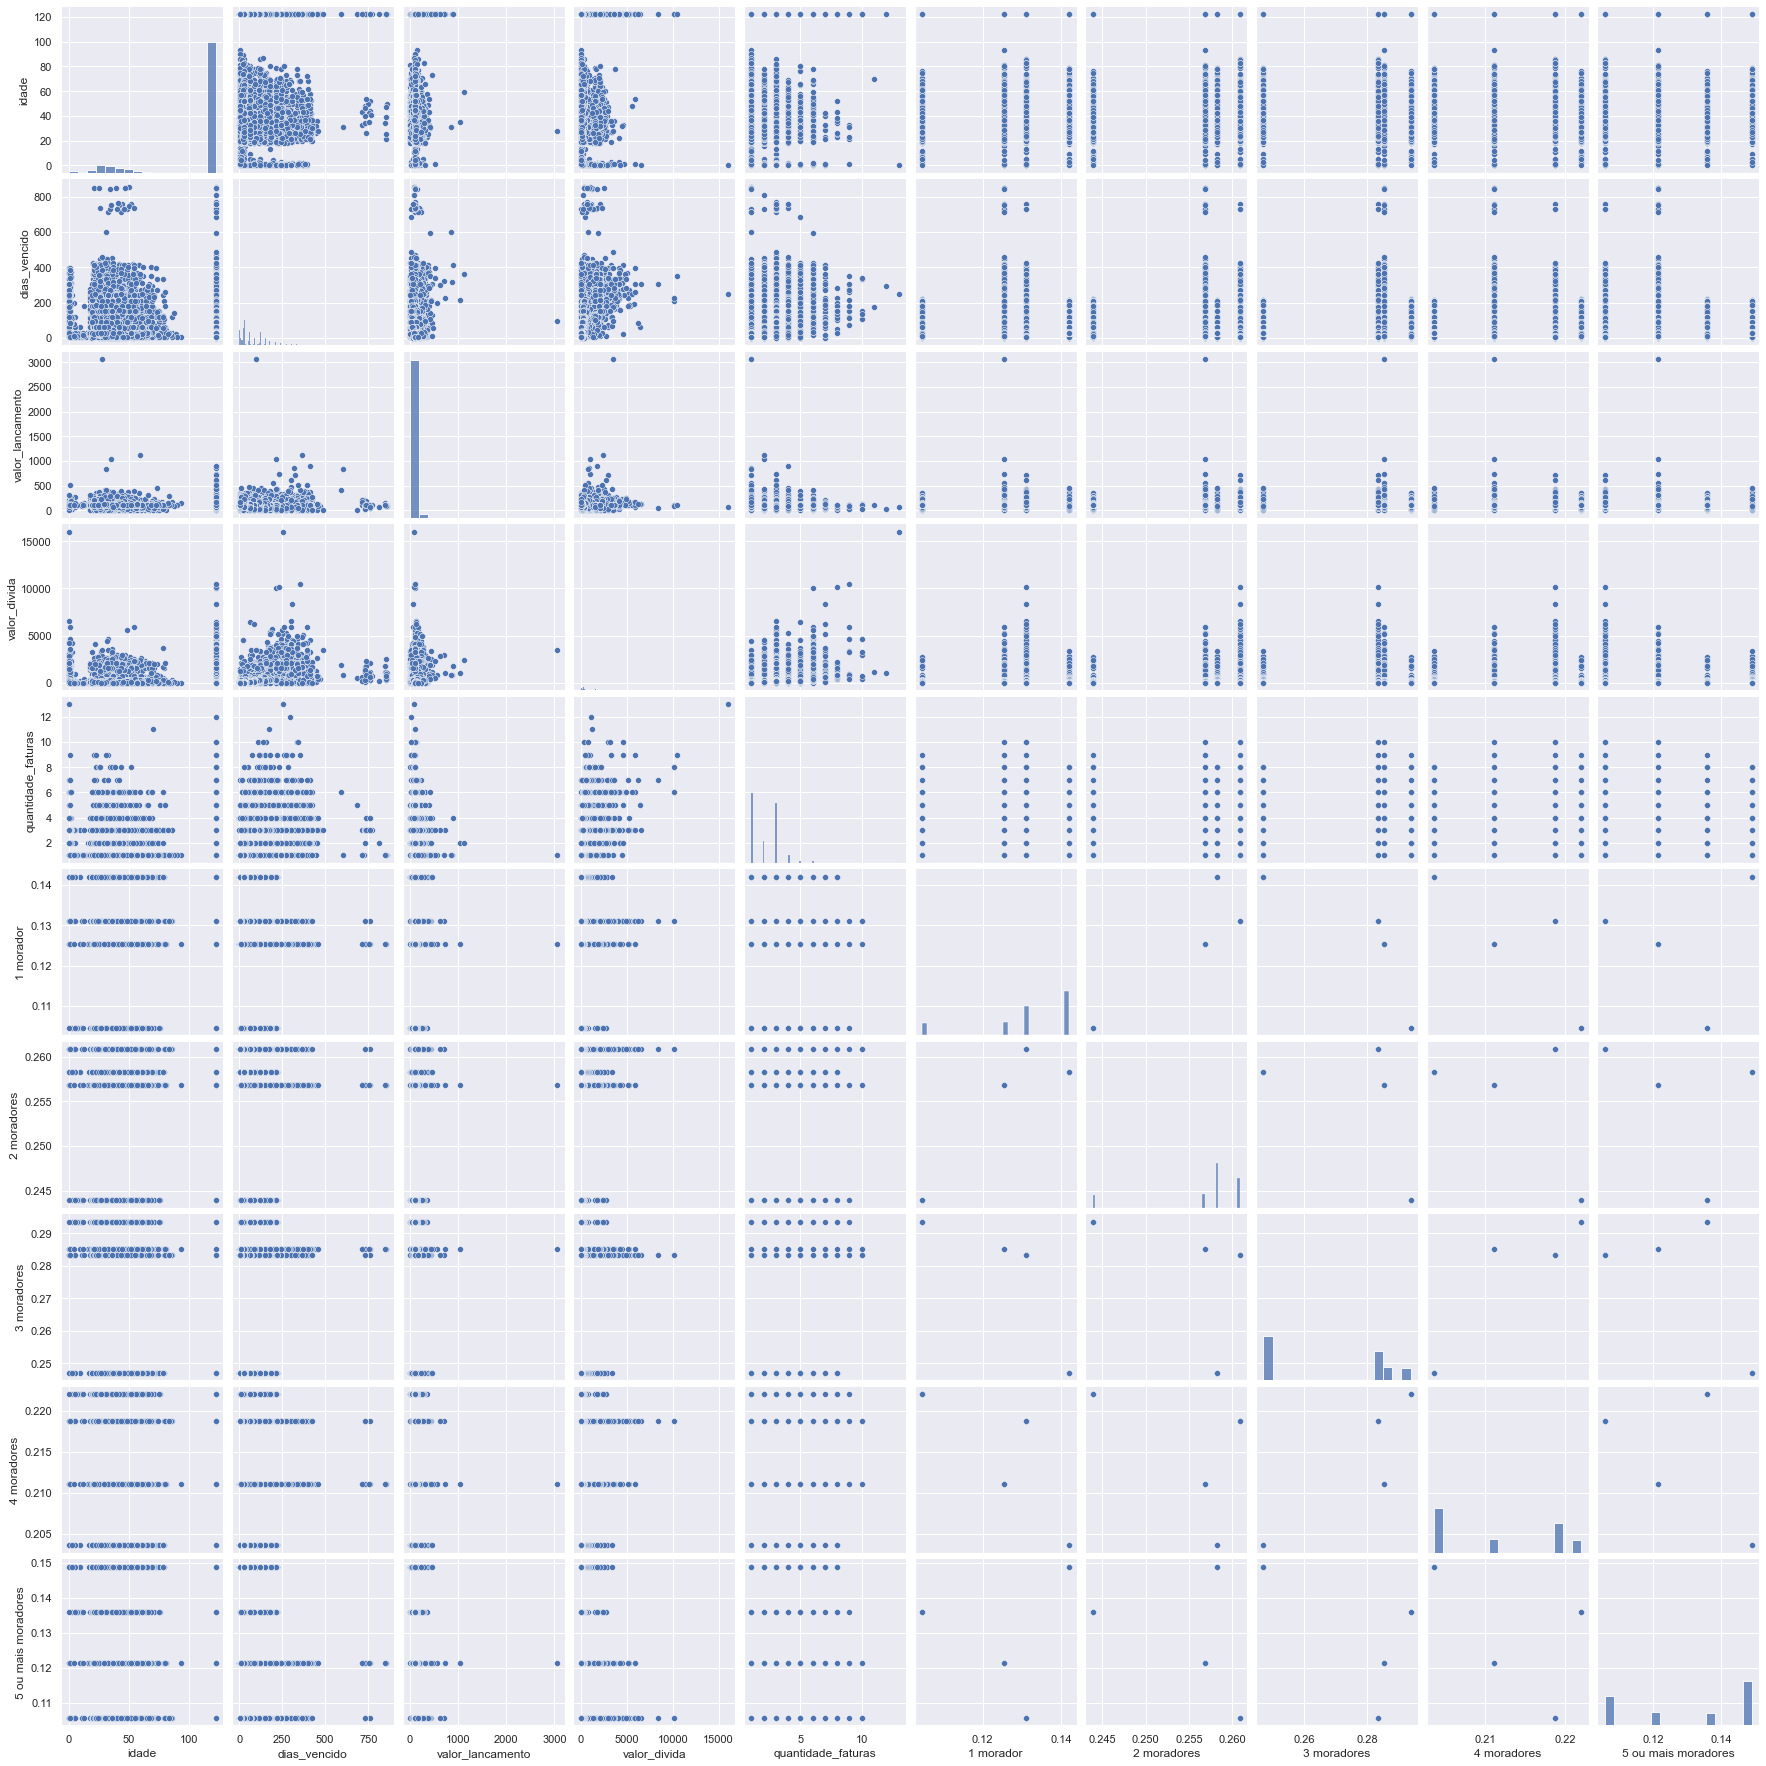

In [ ]:
sns.pairplot(df_demo, vars=['idade', 'dias_vencido', 'valor_lancamento', 'valor_divida', 'quantidade_faturas', '1 morador', '2 moradores', '3 moradores', '4 moradores','5 ou mais moradores'])

In [ ]:
df_demo = pd.merge(devedores, df_demo_instrucao, on='cidade', how='left')
df_demo.corr('spearman')

,cpf_cnpj,idade,codigo_contrato,fatura,dias_vencido,valor_lancamento,valor_divida,quantidade_faturas,FPD,PDD,Unnamed: 0,Fundamental completo e médio incompleto,Médio completo e superior incompleto,Não determinado,Sem instrução e fundamental incompleto,Superior completo
cpf_cnpj,1.000000,0.016965,-0.039461,0.052272,-0.029949,0.016254,-0.015500,-0.025627,-0.034455,-0.016275,NaN,-0.084751,0.037279,-0.109654,-0.037279,0.037279
idade,0.016965,1.000000,0.050422,-0.013650,-0.045772,-0.014473,-0.055060,-0.037271,0.017524,-0.045898,NaN,0.014273,0.011561,0.031612,-0.011561,0.011561
codigo_contrato,-0.039461,0.050422,1.000000,-0.551113,-0.290058,-0.038970,-0.376358,-0.235255,0.281005,-0.396309,NaN,0.409676,-0.141122,0.518439,0.141122,-0.141122
fatura,0.052272,-0.013650,-0.551113,1.000000,-0.426395,0.274690,-0.282281,-0.341412,-0.711572,-0.282781,NaN,-0.355767,0.143689,-0.444200,-0.143689,0.143689
dias_vencido,-0.029949,-0.045772,-0.290058,-0.426395,1.000000,-0.167247,0.814465,0.788581,0.230458,0.831932,NaN,0.071078,-0.069922,0.057935,0.069922,-0.069922
valor_lancamento,0.016254,-0.014473,-0.038970,0.274690,-0.167247,1.000000,0.006068,-0.168454,-0.459902,-0.157010,NaN,-0.053922,0.033694,-0.053135,-0.033694,0.033694
valor_divida,-0.015500,-0.055060,-0.376358,-0.282281,0.814465,0.006068,1.000000,0.768117,0.086294,0.766699,NaN,0.027617,-0.053519,-0.000234,0.053519,-0.053519
quantidade_faturas,-0.025627,-0.037271,-0.235255,-0.341412,0.788581,-0.168454,0.768117,1.000000,0.150019,0.688819,NaN,0.086600,-0.055140,0.103994,0.055140,-0.055140
FPD,-0.034455,0.017524,0.281005,-0.711572,0.230458,-0.459902,0.086294,0.150019,1.000000,0.143010,NaN,0.190101,-0.077810,0.243642,0.077810,-0.077810
PDD,-0.016275,-0.045898,-0.396309,-0.282781,0.831932,-0.157010,0.766699,0.688819,0.143010,1.000000,NaN,-0.025416,-0.023550,-0.064425,0.023550,-0.023550


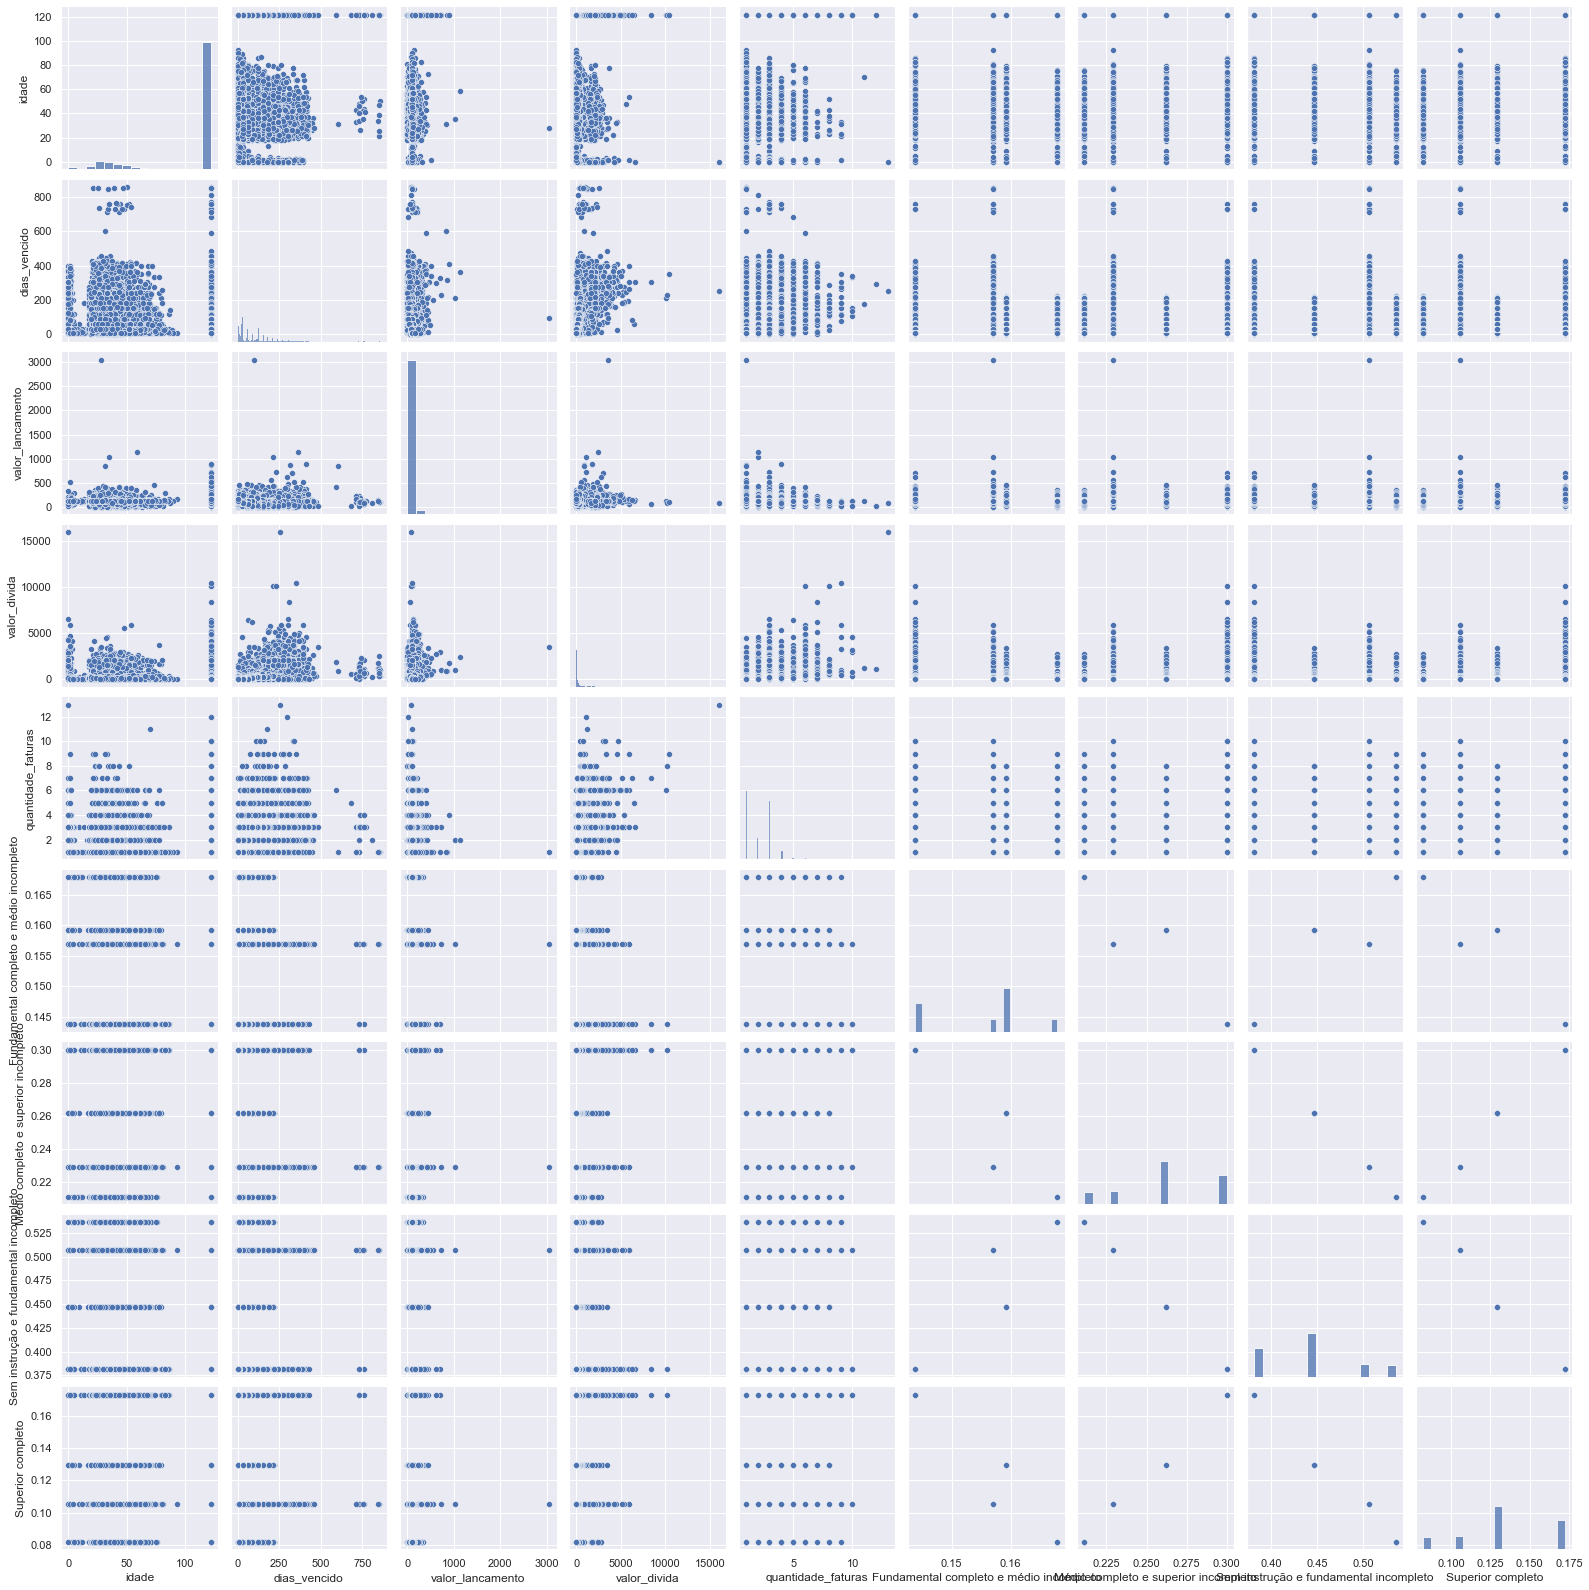

In [ ]:
sns.pairplot(df_demo, vars=['idade', 'dias_vencido', 'valor_lancamento', 'valor_divida', 'quantidade_faturas', 
                            'Fundamental completo e médio incompleto',
                            'Médio completo e superior incompleto',
                            'Sem instrução e fundamental incompleto',
                            'Superior completo'])

### Relações entre váriaveis

In [ ]:
df_demo.head(5)

,cpf_cnpj,nome_razao_social,sexo,idade,grupo_idade,cidade,estado,macroregiao,codigo_contrato,fatura,situacao,dias_vencido,grupo_vencimento,valor_lancamento,valor_divida,quantidade_faturas,FPD,PDD,Unnamed: 0,1 morador,2 moradores,3 moradores,4 moradores,5 ou mais moradores
0,5877043145,RAQUEL SOARES FRANCA,F,122,Idoso,CAMPO GRANDE,MATO GROSSO DO SUL,CENTRO OESTE,168389.0,1,TITULO EM BORDERO,25,0-45,105.97,0.00,1,True,False,0.0,0.142062,0.258251,0.247120,0.203601,0.148965
1,12505066973,YASMIN EDUARDA PIRES,F,122,Idoso,APUCARANA,PARANA,SUL,166806.0,2,TITULO EM BORDERO,25,0-45,119.90,30.94,1,False,False,0.0,0.104548,0.243908,0.293583,0.222035,0.135925
2,3745980964,CLEUZA APARECIDA DO NASCIMENTO,F,48,Adulto Velho,CIANORTE,PARANA,SUL,167794.0,1,TITULO EM BORDERO,25,0-45,94.20,0.00,1,True,False,NaN,NaN,NaN,NaN,NaN,NaN
3,8986375117,EDUARDO OLIVEIRA CAMARGO,M,122,Idoso,CAMPO GRANDE,MATO GROSSO DO SUL,CENTRO OESTE,168013.0,1,TITULO EM BORDERO,25,0-45,119.90,0.00,1,True,False,0.0,0.142062,0.258251,0.247120,0.203601,0.148965
4,2263029117,ANDRE LUIS GONCALVES DA SILVA,M,122,Idoso,CAMPO GRANDE,MATO GROSSO DO SUL,CENTRO OESTE,174352.0,1,TITULO EM BORDERO,25,0-45,18.56,0.00,1,True,False,0.0,0.142062,0.258251,0.247120,0.203601,0.148965


<AxesSubplot:xlabel='dias_vencido', ylabel='idade'>

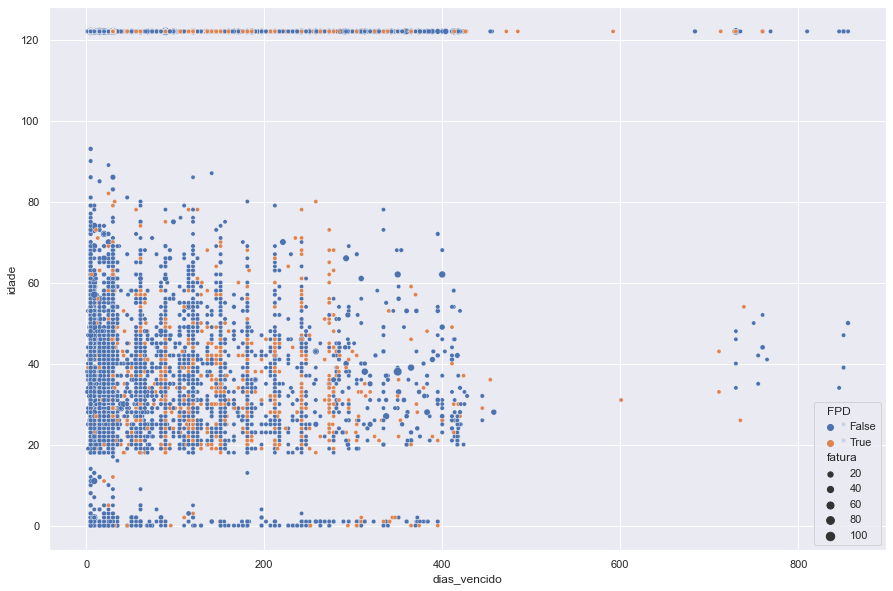

In [ ]:
sns.scatterplot(data=devedores, x='dias_vencido', y='idade', hue='FPD', size='fatura')

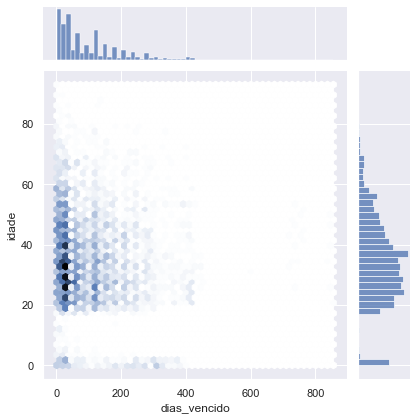

In [ ]:
sns.jointplot(data=devedores.query('idade < 100'), x='dias_vencido', y='idade', kind='hex')

<AxesSubplot:xlabel='dias_vencido', ylabel='valor_divida'>

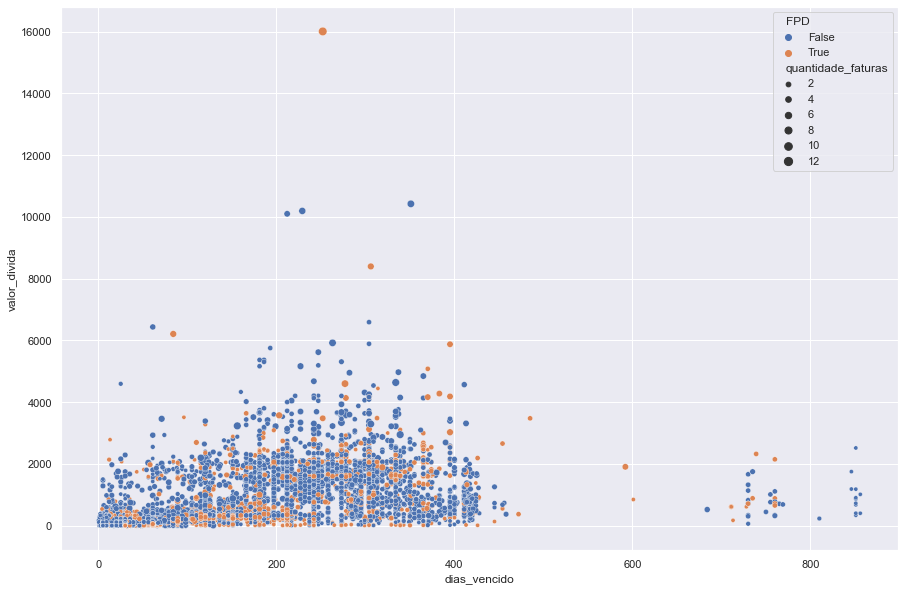

In [ ]:
sns.scatterplot(data=devedores, x='dias_vencido', y='valor_divida', hue='FPD', size='quantidade_faturas')

<AxesSubplot:xlabel='dias_vencido', ylabel='quantidade_faturas'>

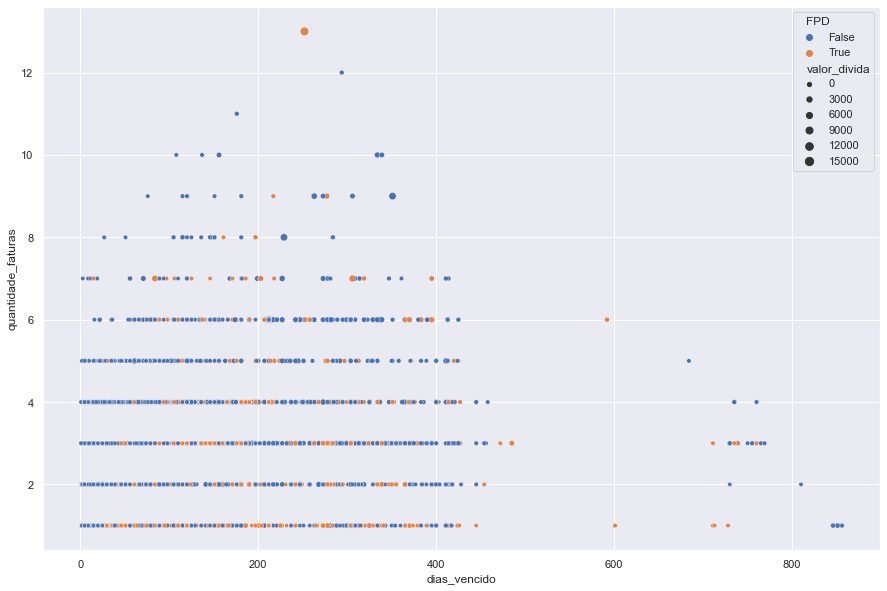

In [ ]:
sns.scatterplot(data=devedores, x='dias_vencido', y='quantidade_faturas', hue='FPD', size='valor_divida')